In [1]:
import os
import torch
import logging
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
!pip install transformers
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

import random
USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    DEVICE = torch.device('cuda')
    print("Using cuda.")
else:
    DEVICE = torch.device('cpu')
    print("Using cpu.")

seed = 30255    
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if USE_CUDA:
    torch.cuda.manual_seed(seed)

# For uploading data to Colab see, e.g., 
# https://medium.com/@philipplies/transferring-data-from-google-drive-to-google-cloud-storage-using-google-colab-96e088a8c041    


from google.colab import drive 
drive.mount('/content/gdrive')
PATH = "gdrive/MyDrive/climate-paper-classifier/data"
    


Using cpu.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
python3: can't open file '/content/trainingScripty.py': [Errno 2] No such file or directory


In [3]:
import pandas as pd
import numpy as np
import torch
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from transformers import BertTokenizer
import os

path = os.path.abspath(os.path.join(PATH, 'preprocessed_data.csv'))
df = pd.read_csv(path)

seed = 30255    
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

class Processing():
    def __init__(self, seq_len=512, batch_size=32):
        self.df = pd.DataFrame()
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None
        self.vocab = pd.DataFrame()
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_words = 0

    def load(self):
        from sklearn import preprocessing
        self.df = pd.read_csv(path)
        self.df = self.df[['CLASS', 'SPACY_PREPROCESSED']]
        
        self.df = self.df.dropna()
        self.df['SPACY_PREPROCESSED'] = self.df['SPACY_PREPROCESSED'].str.replace(r'<[^<>]*>', '', regex=True) # drop HTML tags

        le = preprocessing.LabelEncoder()
        le.fit(self.df['CLASS'])
        self.df['LABEL'] = le.transform(self.df['CLASS'])

        self.df = self.df[['LABEL', 'SPACY_PREPROCESSED']]

        self.df['LABEL'].value_counts(dropna=False)
        

        self.text = self.df["SPACY_PREPROCESSED"].values
        self.target = self.df["LABEL"].values
    
    def tokenize_and_build_vocabulary(self):
        from torchtext.data.utils import get_tokenizer
        from torchtext.vocab import build_vocab_from_iterator

        tokenizer = get_tokenizer('basic_english')

        def yield_tokens(train_iter):
            for text in train_iter:
                yield tokenizer(text)

        # tokenize and build vocab over all words 
        train_iter = iter(self.text.tolist())
        self.tokenized = list(map(lambda text : tokenizer(text), train_iter))
        # re-initialize train iter
        train_iter = iter(self.text.tolist())
        # build vocab
        self.vocab = build_vocab_from_iterator(
            yield_tokens(train_iter), specials=["<unk>"], max_tokens = self.seq_len)
        self.vocab.set_default_index(self.vocab['<unk>'])
        # set num words in vocab
        self.num_words = len(self.vocab)

    def word_to_idx(self):
        # Index representation	
        self.index_representation = list()
        for sentence in self.tokenized:
            temp_sentence = list()
            for word in sentence:
                idx = self.vocab.lookup_indices([word])
                temp_sentence.extend(self.vocab.lookup_indices([word]))
            self.index_representation.append(temp_sentence)

    def padding_sentences(self):
        # Pad each sentence which does not fulfill the required len
        # Zero padding

        pad_idx = 0
        self.padded = list()
        for sentence in self.index_representation: # tensors
            if len(sentence) < self.seq_len:
                while len(sentence) < self.seq_len: #max_length
                    sentence.append(pad_idx)
                sentence = torch.tensor(sentence)
                self.padded.append(sentence)
            else:
                sentence = torch.tensor(sentence[:self.seq_len])
                self.padded.append(sentence) # new code
        self.padded = torch.stack(self.padded)

    def split_data(self):
        self.target = torch.tensor(self.target)
        # Concatenating the Padded Vectors, Labels
        dataset = TensorDataset(self.padded, self.target)

        # compute train/validation/test split sizes
        train_size = int(0.7 * len(dataset))
        val_size = int(0.15 * len(dataset))
        test_size = len(dataset) - train_size - val_size

        # split dataset randomly into train/validation/test sets
        train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

        # create data loaders for each set
        self.train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_data, batch_size=self.batch_size, shuffle=True)
        self.test_loader = DataLoader(test_data, batch_size=self.batch_size, shuffle=True)


    def process_all(self):
        self.load()
        self.tokenize_and_build_vocabulary()
        self.word_to_idx()
        self.padding_sentences()
        self.split_data()

    def prints(self):
        # Task 1
        print(f"Task 1: The number of words in the Vocab object is {len(self.vocab)}.")

        # # Task 2
        stoi_dict = self.vocab.get_stoi()
        word = "energy"
        print(f"Task 2: The index of the word '{word}' is {stoi_dict[word]}.")

        # # Task 3
        itos_dict = self.vocab.get_itos()
        idx = 500
        print(f"Task 3: The word at index 500 is '{itos_dict[idx]}'.")

        # # Task 4:
        word = "<unk>"
        print(f"Task 4: The index of the word '{word}' is {stoi_dict[word]}. Resetting default index to this value.")


/content/gdrive/MyDrive/climate-paper-classifier/data/preprocessed_data.csv


In [4]:
data = Processing()
data.load()

In [5]:
import torch
import torch.nn as nn
import math
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# source: https://coderzcolumn.com/tutorials/artificial-intelligence/pytorch-conv1d-for-text-classification

class CNN(nn.Module):
    def __init__(self, use_glove=True, kernel_size=5, channel_size=32, seq_len=512, batch_size=32):
        super(CNN, self).__init__()
        self.data = Processing(seq_len, batch_size)
        self.data.process_all()
        self.use_glove = use_glove
        self.embedding_layer = nn.Embedding(num_embeddings=len(self.data.vocab), embedding_dim=128)
        if use_glove:
            self.embedding_pretrained = nn.Embedding.from_pretrained(glove_vectors, freeze=False)
            self.conv1 = nn.Conv1d(300, 32, kernel_size=5, padding="same")
        else:
          self.conv1 = nn.Conv1d(128, 32, kernel_size=5, padding="same")

        self.pooling1 = nn.MaxPool1d(2)
        self.linear = nn.Linear(32, 5)

    def forward(self, X_batch):
        if self.use_glove:
          x = self.embedding_pretrained(X_batch)
          x = x.transpose(1, 2)
          x = nn.functional.relu(self.conv1(x))
          x = self.pooling1(x)
          x, _ = x.max(dim=-1)
          x = self.linear(x)
          return x
        else:
          x = self.embedding_layer(X_batch)
          # Transpose the tensor to shape [16, 128, 930]
          x = x.transpose(1, 2)
          x = nn.functional.relu(self.conv1(x))
          x = self.pooling1(x)
          x, _ = x.max(dim=-1)
          x = self.linear(x)
          return x

In [6]:
import os
!pip install torchtext
import torchtext

data = Processing()
data.process_all()

cache_dir: str = '~/.vector_cache'
glove = torchtext.vocab.GloVe('6B', cache=cache_dir)

print(f"Glove embedding files:\
    {os.listdir(cache_dir)} in {os.path.abspath(cache_dir)}")

glove_vectors = glove.get_vecs_by_tokens(data.vocab.get_itos())
print(f"Glove vectors tensor shape: {glove_vectors.shape}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Glove embedding files:    ['glove.6B.50d.txt', 'glove.6B.300d.txt.pt', 'glove.6B.200d.txt', 'glove.6B.zip', 'glove.6B.300d.txt', 'glove.6B.100d.txt'] in /content/~/.vector_cache
Glove vectors tensor shape: torch.Size([512, 300])


In [7]:

from sklearn.metrics import accuracy_score

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        # print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        # print("Valid Acc  : {:.3f}\n".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))
        return losses, accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())
    


torch.Size([16, 512]) torch.Size([16])
Epoch 0 Step 200 Train Loss: 1.026 Valid Loss: 0.787 Valid Acc: 0.720
Epoch 1 Step 200 Train Loss: 0.573 Valid Loss: 0.710 Valid Acc: 0.742
Epoch 2 Step 200 Train Loss: 0.428 Valid Loss: 0.682 Valid Acc: 0.747
Epoch 3 Step 200 Train Loss: 0.308 Valid Loss: 0.675 Valid Acc: 0.748
Epoch 4 Step 200 Train Loss: 0.209 Valid Loss: 0.706 Valid Acc: 0.755
Epoch 5 Step 200 Train Loss: 0.135 Valid Loss: 0.738 Valid Acc: 0.747
Epoch 6 Step 200 Train Loss: 0.082 Valid Loss: 0.752 Valid Acc: 0.748
Epoch 7 Step 200 Train Loss: 0.052 Valid Loss: 0.787 Valid Acc: 0.749
Epoch 8 Step 200 Train Loss: 0.039 Valid Loss: 0.818 Valid Acc: 0.750
Epoch 9 Step 200 Train Loss: 0.033 Valid Loss: 0.887 Valid Acc: 0.750


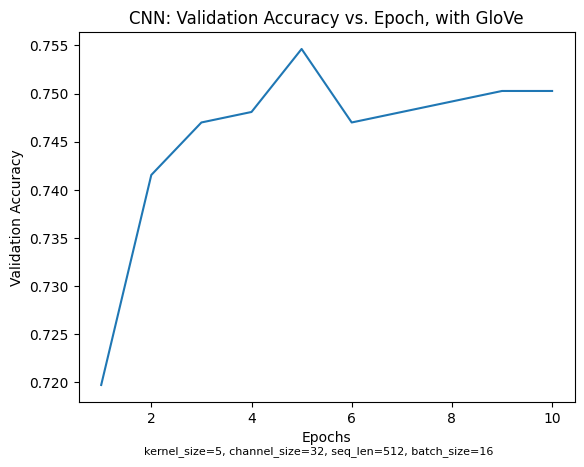

In [8]:
seed = 30255    
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
%matplotlib inline

def train(use_glove=True, kernel_size=5, channel_size=32, 
          seq_len=512, batch_size=32, save_name="test", 
          plot_title=""):
  # Model      
  model = CNN(use_glove=use_glove, kernel_size=kernel_size, 
              channel_size=channel_size, seq_len=seq_len, 
              batch_size=batch_size)
  # Opmization function
  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  # Loss function
  loss_fn = nn.CrossEntropyLoss()
  # Data
  data = model.data
  loader_train = data.train_loader
  loader_val = data.val_loader
  loader_test = data.test_loader

  for X, Y in loader_val:
      print(X.shape, Y.shape)
      break

  epochs = 10
  learning_rate = 1e-3

  all_losses = []
  all_acc = []
  best_model = None

  for i in range(epochs):
      losses = []
      for k, (X, Y) in enumerate(loader_train):
          Y_preds = model(X)
          loss = loss_fn(Y_preds, Y)
          losses.append(loss.item())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          clip_grad_norm_(model.parameters(), 1)

          step = (k+1)
          if step % 200 == 0:
              loss, accuracy = CalcValLossAndAccuracy(model, loss_fn, loader_val)

              all_acc.append(accuracy)
              print("Epoch", i, "Step", step, "Train Loss: {:.3f}".format(torch.tensor(losses).mean()), 
                    "Valid Loss: {:.3f}".format(torch.tensor(loss).mean()),
                    "Valid Acc: {:.3f}".format(accuracy))
              if len(all_losses) > 0:
                if torch.tensor(loss).mean() > all_losses[-1]:
                  model_copy = type(model)(use_glove=use_glove, 
                                           kernel_size=kernel_size, 
                                           channel_size=channel_size, 
                                           seq_len=seq_len, 
                                           batch_size=batch_size)
                  model_copy.load_state_dict(model.state_dict()) # copy weights and stuff
                  best_model = model_copy
              else:
                all_losses.append(torch.tensor(loss).mean())
                model_copy = type(model)(use_glove=use_glove, 
                                         kernel_size=kernel_size, 
                                         channel_size=channel_size, 
                                         seq_len=seq_len, 
                                         batch_size=batch_size)
                model_copy.load_state_dict(model.state_dict()) # copy weights and stuff
                best_model = model_copy

  caption = "kernel_size=5, channel_size=32, seq_len=512, batch_size=16"
  plt.plot(range(1, epochs+1), all_acc)
  plt.title(plot_title)
  plt.xlabel("Epochs")
  plt.ylabel("Validation Accuracy")
  plt.figtext(0.5, 0.001, caption, wrap=True, horizontalalignment='center', fontsize=8)
  plt.savefig(f'{save_name}.png')
  plt.show()

  return best_model, loader_test

kernel_size=5
channel_size=32
seq_len=512
batch_size=16
plot_title = "CNN: Validation Accuracy vs. Epoch, with GloVe"
save_name="plt-5-32-512-32"

best_model, loader_test = train(kernel_size=kernel_size, 
                                channel_size=channel_size, 
                                seq_len=seq_len, 
                                batch_size=batch_size, 
                                save_name=save_name, 
                                plot_title=plot_title)



In [9]:
import gc
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), nn.functional.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(best_model, loader_test)
!pip install sklearn
from sklearn.metrics import f1_score

labels = ["Energy Storage, Conversion, and Utilization","Environmental Sciences",
          "Fission and Nuclear Technologies","Fossil Fuels","Renewable Energy Sources"]
f1 = f1_score(Y_actual, Y_preds, average=None, labels=[0,1,2,3,4])
logging.info(f"Best Model F1 Score={f1}")

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report
import pandas as pd
multilabel_confusion_matrix(Y_actual, Y_preds)
print(classification_report(Y_actual, Y_preds, target_names=labels))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
                                             precision    recall  f1-score   support

Energy Storage, Conversion, and Utilization       0.78      0.71      0.74       189
                     Environmental Sciences       0.74      0.74      0.74       179
           Fission and Nuclear Technologies       0.82      0.86      0.84       184
                               Fossil Fuels       0.78      0.76      0.77       180
                   Renewable Energy Sources       0.67      0.72      0.69       186

                                   accuracy                           0.76       918
                                  macro avg       0.76      0.76      0.76       918
                               weighted avg       0.76      0.76      0.76       918

